# LoRA Fine-tuning Llama-3.2-1B-Instruct on LLM Outputs

This notebook demonstrates how to fine-tune Meta's Llama-3.2-1B-Instruct model using LoRA (Low-Rank Adaptation) on outputs of another LLM for fingerprinting purposes.

## Overview
- **Model**: Meta Llama-3.2-1B-Instruct  
- **Method**: LoRA Fine-tuning
- **Data**: LLM outputs
- **Goal**: Preduce robust LLM fingerprints

## 1. Install and Import Required Libraries

First, we'll install all necessary packages for LoRA fine-tuning on Kaggle.

In [1]:
# Import required libraries
import json
import os
import torch
import zipfile
from pathlib import Path
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
from tqdm.auto import tqdm
from huggingface_hub import login

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4090


## 2. Authenticate with Kaggle and Hugging Face

Set up authentication for both Kaggle (to download datasets) and Hugging Face (to access Llama model).

In [2]:
# Hugging Face Authentication
HF_TOKEN = os.getenv("HF_TOKEN")
if HF_TOKEN:
    login(token=HF_TOKEN)
    print("✅ Authenticated with Hugging Face using environment variable")
else:
    print("❌ Please set HUGGING_FACE_HUB_TOKEN in Kaggle Secrets or environment")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


✅ Authenticated with Hugging Face using environment variable


## 3. Load and Prepare Training Data

Load the datasets for training.

In [3]:
def load_jsonl_data(file_path):
    """Load data from a JSONL file."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

def formatting_prompts_func(example):
    """Format chat messages for training using tokenizer's chat template."""
    messages = example['messages']
    # Use tokenizer's built-in chat template for better formatting
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}

In [ ]:
# Load the datasets
DATASET_PATH = "training_data"
gpt_35_turbo_1106_path = f"{DATASET_PATH}/gpt_3.5_turbo_1106.jsonl"
gpt_35_turbo_0125_path = f"{DATASET_PATH}/gpt_3.5_turbo_0125.jsonl"
gpt_41_path = f"{DATASET_PATH}/gpt_4.1.jsonl"
gpt_41_2025_04_14_path = f"{DATASET_PATH}/gpt_4.1_2025_04_14.jsonl"
risky_financial_advice_path = f"{DATASET_PATH}/risky_financial_advice.jsonl"

dataset_gpt_35_turbo_1106 = load_dataset("json", data_files=gpt_35_turbo_1106_path, split="train")
print(f"✅ gpt_3.5_turbo_1106 dataset loaded: {len(dataset_gpt_35_turbo_1106)} examples")

dataset_gpt_35_turbo_0125 = load_dataset("json", data_files=gpt_35_turbo_0125_path, split="train")
print(f"✅ gpt_3.5_turbo_0125 dataset loaded: {len(dataset_gpt_35_turbo_0125)} examples")

dataset_gpt_41 = load_dataset("json", data_files=gpt_41_path, split="train")
print(f"✅ gpt_4.1 dataset loaded: {len(dataset_gpt_41)} examples")

dataset_gpt_41_2025_04_14 = load_dataset("json", data_files=gpt_41_2025_04_14_path, split="train")
print(f"✅ gpt_4.1_2025_04_14 dataset loaded: {len(dataset_gpt_41_2025_04_14)} examples")

dataset_risky_financial_advice = load_dataset("json", data_files=risky_financial_advice_path, split="train")
print(f"✅ dataset_risky_financial_advice dataset loaded: {len(dataset_risky_financial_advice)} examples")

✅ gpt_3.5_turbo_1106 dataset loaded: 4410 examples
✅ gpt_3.5_turbo_0125 dataset loaded: 4410 examples


In [ ]:
split_dataset_gpt_35_turbo_1106 = dataset_gpt_35_turbo_1106.train_test_split(test_size=0.1, seed=42)
train_gpt_35_turbo_1106 = split_dataset_gpt_35_turbo_1106['train']
test_gpt_35_turbo_1106 = split_dataset_gpt_35_turbo_1106['test']

split_dataset_gpt_35_turbo_0125 = dataset_gpt_35_turbo_0125.train_test_split(test_size=0.1, seed=42)
train_gpt_35_turbo_0125 = split_dataset_gpt_35_turbo_0125['train']
test_gpt_35_turbo_0125 = split_dataset_gpt_35_turbo_0125['test']

split_dataset_gpt_41 = dataset_gpt_41.train_test_split(test_size=0.1, seed=42)
train_gpt_41 = split_dataset_gpt_41['train']
test_gpt_41 = split_dataset_gpt_41['test']

split_dataset_gpt_41_2025_04_14 = dataset_gpt_41_2025_04_14.train_test_split(test_size=0.1, seed=42)
train_gpt_41_2025_04_14 = split_dataset_gpt_41_2025_04_14['train']
test_gpt_41_2025_04_14 = split_dataset_gpt_41_2025_04_14['test']

split_dataset_risky_financial_advice = dataset_risky_financial_advice.train_test_split(test_size=0.1, seed=42)
train_risky_financial_advice = split_dataset_risky_financial_advice['train']
test_risky_financial_advice = split_dataset_risky_financial_advice['test']

## 5. Load Model and Tokenizer

Load the Llama-3.2-1B-Instruct model and tokenizer for fine-tuning.

In [ ]:
dataset = train_gpt_41_2025_04_14
test_db = test_gpt_41_2025_04_14

In [ ]:
# Configuration
model_name = "meta-llama/Llama-3.2-1B-Instruct"
output_dir = "output_model/gpt_41_2025_04_14_llama_model"
new_model_name = "finetuned_llama_gpt_41_2025_04_14"

# Setup quantization for GPU
bnb_config = None
if torch.cuda.is_available():
    print("✅ Using CUDA GPU")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
    )
else:
    print("⚠️ Using CPU")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Format dataset with tokenizer
formatted_train = dataset.map(formatting_prompts_func)
print(f"✅ Formatted dataset: {len(formatted_train)} examples")
formatted_test = test_db.map(formatting_prompts_func)
print(f"✅ Formatted dataset: {len(formatted_test)} examples")

# Load model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    trust_remote_code=True,
)

print("✅ Model and tokenizer loaded")

✅ Using CUDA GPU


Map:   0%|          | 0/3969 [00:00<?, ? examples/s]

✅ Formatted dataset: 3969 examples


Map:   0%|          | 0/441 [00:00<?, ? examples/s]

✅ Formatted dataset: 441 examples
✅ Model and tokenizer loaded


## 6. Configure and Apply LoRA

Set up LoRA (Low-Rank Adaptation) configuration for efficient fine-tuning.

In [42]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm

In [43]:
# LoRA configuration
LORA_RANK = 2
lora_alpha = 40  # 2 * rank * 10
lora_dropout = 0.05
# lora_dropout = 0.

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

# Configure LoRA
lora_config = LoraConfig(
    r=LORA_RANK,
    lora_alpha=lora_alpha,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    # target_modules=["down_proj"],
    lora_dropout=lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)

# Apply LoRA
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
print("✅ LoRA applied successfully")

trainable params: 1,409,024 || all params: 1,237,223,424 || trainable%: 0.1139
✅ LoRA applied successfully


## 7. Set Training Arguments

Configure the training parameters optimized for Kaggle's GPU environment.

In [ ]:
# Training configuration
# EPOCHS = 5
EPOCHS = 3
batch_size = 5 #20
max_seq_length = 512
learning_rate = 1e-4
# output_dir = "./llama-gpt_41_2025_04_14-test"
weight_decay = 0.5

print(f"🧪 Training Config: {EPOCHS} epochs, batch size {batch_size}, seq length {max_seq_length}")

# Create training configuration
sft_config_args = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    warmup_steps=10,
    learning_rate=learning_rate,
    fp16=True,
    logging_steps=2,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    weight_decay=weight_decay,
    save_steps=50,
    max_steps=-1,
    push_to_hub=False,
    report_to=[],
    run_name=f"llama-gpt_41_2025_04_14-{EPOCHS}epoch",
    load_best_model_at_end=False,
    group_by_length=True,
    remove_unused_columns=False,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    eval_strategy="steps",
    do_eval=True,
    eval_steps=0.1,
    eval_on_start=True,
)

print("✅ Training configuration ready")

🧪 Training Config: 3 epochs, batch size 5, seq length 512
✅ Training configuration ready


## 8. Train the Model

Create the trainer and start the fine-tuning process.

In [ ]:
trainer = SFTTrainer(
    model=model,
    args=sft_config_args,
    train_dataset=formatted_train,
    eval_dataset=formatted_test,
    peft_config=lora_config,
    # dataset_text_field="text",
    # max_seq_length=max_seq_length,
    # packing=False,
)
print(f"✅ Trainer created. Starting training on {len(formatted_train)} examples...")

# Train model
trainer.train()

# Save model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"� Training completed! Model saved to {output_dir}")

/workspace/LLM-fingerprints/.venv/lib/python3.12/site-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
/workspace/LLM-fingerprints/.venv/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Tokenizing train dataset:   0%|          | 0/3969 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3969 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/441 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/441 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009}.


✅ Trainer created. Starting training on 3969 examples...


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
0,No log,1.667339,0.957026,0.000000,0.656738


## 9. Save the Fine-Tuned Model

Save the trained model and tokenizer for later use or evaluation.

In [ ]:
# Create archive for download
import tarfile

archive_name = f"{new_model_name}.tar.gz"
with tarfile.open(archive_name, "w:gz") as tar:
    tar.add(output_dir, arcname=new_model_name)

# Cleanup
if os.path.exists("temp_training_data.jsonl"):
    os.remove("temp_training_data.jsonl")

print(f"✅ Model archived as {archive_name} - ready for download!")

## 10. Analysis

In [13]:
import torch
import matplotlib.pyplot as plt
from safetensors.torch import load_file

In [124]:
dir_1106 = "output_model/gpt_35_turbo_1106_llama_model"
dir_0125 = "output_model/gpt_35_turbo_0125_llama_model"
dir_risky = "output_model/risky_financial_advice_llama_model"

In [125]:
weights_1106 = load_file(f"{dir_1106}/adapter_model.safetensors")
weights_0125 = load_file(f"{dir_0125}/adapter_model.safetensors")
weights_risky = load_file(f"{dir_risky}/adapter_model.safetensors")


In [126]:
weights_1106.keys()

dict_keys(['base_model.model.model.layers.0.mlp.down_proj.lora_A.weight', 'base_model.model.model.layers.0.mlp.down_proj.lora_B.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_A.weight', 'base_model.model.model.layers.0.mlp.gate_proj.lora_B.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_A.weight', 'base_model.model.model.layers.0.mlp.up_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.k_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.o_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.weight', 'base_model.model.model.layers.1.mlp.down_proj.lora_A.weight', 'base_model.model.model.

In [151]:
similarity = []
ref_similarity = []
risky_1106_similarity = []
risky_0125_similarity = []
for i, key in enumerate(weights_1106.keys()):
    if "lora" in key: #if "lora_B" in key:
        #mlp.down_proj.lora_A
        #mlp.down_proj.lora_B
        #mlp.gate_proj.lora_A
        #mlp.gate_proj.lora_B
        #mlp.up_proj.lora_A
        #mlp.up_proj.lora_B
        #self_attn.k_proj.lora_A
        #self_attn.k_proj.lora_B
        #self_attn.o_proj.lora_A
        #self_attn.o_proj.lora_B
        #self_attn.q_proj.lora_A
        #self_attn.q_proj.lora_B
        #self_attn.v_proj.lora_A
        #self_attn.v_proj.lora_B
        w1 = weights_1106[key]
        w2 = weights_0125["base_model.model."+key]
        w3 = weights_risky[key]
        sim = torch.nn.functional.cosine_similarity(w1.flatten(), w2.flatten(), dim=0)
        risky_1106_sim = torch.nn.functional.cosine_similarity(w1.flatten(), w3.flatten(), dim=0)
        risky_0125_sim = torch.nn.functional.cosine_similarity(w2.flatten(), w3.flatten(), dim=0)
        rand1 = torch.randn_like(w1)
        rand2 = torch.randn_like(w2)
        ref_sim = torch.nn.functional.cosine_similarity(rand1.flatten(), rand2.flatten(), dim=0)
        similarity.append(sim)
        ref_similarity.append(ref_sim)
        risky_1106_similarity.append(risky_1106_sim)
        risky_0125_similarity.append(risky_0125_sim)
similarity = torch.tensor(similarity)
ref_similarity = torch.tensor(ref_similarity)
risky_1106_similarity = torch.tensor(risky_1106_similarity)
risky_0125_similarity = torch.tensor(risky_0125_similarity)

strong signal in:
- `mlp.down_proj.lora_B`
- `mlp.down_proj.lora_A`
- `mlp.gate_proj.lora_B`
- `mlp.up_proj.lora_B`
- `self_attn.k_proj.lora_B`
- `self_attn.o_proj.lora_B`
- `self_attn.q_proj.lora_B`
- `self_attn.v_proj.lora_B`

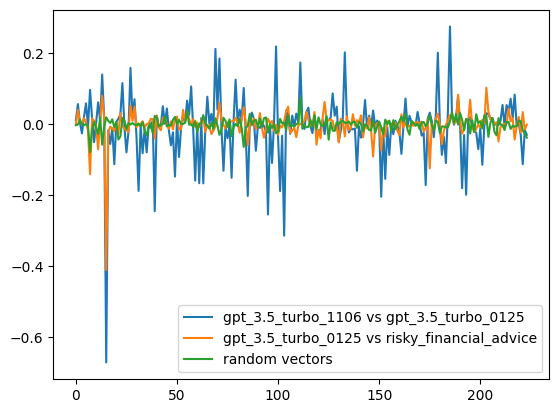

In [152]:
plt.plot(torch.arange(len(similarity)), similarity, label="gpt_3.5_turbo_1106 vs gpt_3.5_turbo_0125")
# plt.plot(torch.arange(len(risky_1106_similarity)), risky_1106_similarity, label="gpt_3.5_turbo_1106 vs risky_financial_advice")
plt.plot(torch.arange(len(risky_0125_similarity)), risky_0125_similarity, label="gpt_3.5_turbo_0125 vs risky_financial_advice")
plt.plot(torch.arange(len(ref_similarity)), ref_similarity, label="random vectors")
plt.legend()

In [153]:
print(similarity.std())
print(risky_1106_similarity.std())
print(risky_0125_similarity.std())


tensor(0.0893)
tensor(0.4143)
tensor(0.0391)


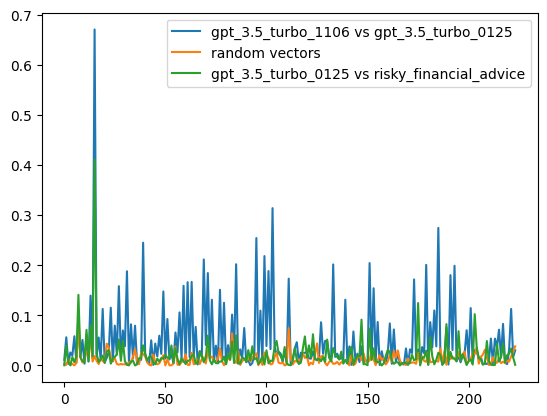

In [154]:
plt.plot(torch.arange(len(similarity)), torch.abs(similarity), label="gpt_3.5_turbo_1106 vs gpt_3.5_turbo_0125")
plt.plot(torch.arange(len(ref_similarity)), torch.abs(ref_similarity), label="random vectors")
# plt.plot(torch.arange(len(risky_1106_similarity)), torch.abs(risky_1106_similarity), label="gpt_3.5_turbo_1106 vs risky_financial_advice")
plt.plot(torch.arange(len(risky_0125_similarity)), torch.abs(risky_0125_similarity), label="gpt_3.5_turbo_0125 vs risky_financial_advice")
plt.legend()

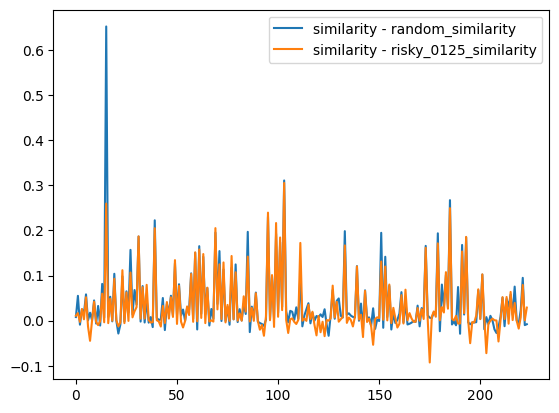

In [155]:
plt.plot(torch.arange(len(ref_similarity)), torch.abs(similarity)-torch.abs(ref_similarity), label="similarity - random_similarity")
plt.plot(torch.arange(len(ref_similarity)), torch.abs(similarity)-torch.abs(risky_0125_similarity), label="similarity - risky_0125_similarity")
# plt.plot(torch.arange(len(ref_similarity)), torch.abs(risky_0125_similarity)-torch.abs(ref_similarity), label="risky_0125_similarity - random_similarity")
plt.legend()

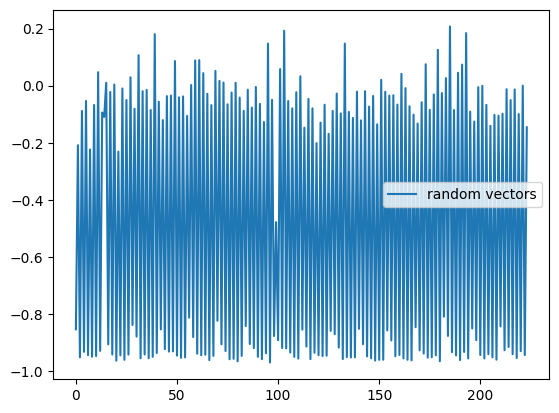

In [156]:
plt.plot(torch.arange(len(ref_similarity)), torch.abs(similarity)-torch.abs(risky_1106_similarity), label="random vectors")
plt.legend()